In [1]:
import ROOT as root
import numpy as np
import random
from timer import Timer

t = Timer()
t.start()

Welcome to JupyROOT 6.24/06


In [2]:
Analyse_Secondaries = 1
Theta_min_cut = 2.524
ThetaVerticalCut = 3.02

MaxHits = 50000
MaxPMTNo = 20
MaxPMTHits = 5000
Finger_Edep_Max = 10.0
AnaBar_Edep_Max = 10.0
pedastel_sigma = 2.9
Detector_Offset = 0

Finger_NPhotons_Max = 250
AnaBar_NPhotons_Max = 200

NUMPADDLE = 14

NMaxPMT = 14

Detector_pdg = np.array([0 for i in range(MaxHits)],dtype=int)
Detector_id = np.array([0 for i in range(MaxHits)],dtype=int)

Detector_x = np.array([0 for i in range(MaxHits)],dtype=float)
Detector_y = np.array([0 for i in range(MaxHits)],dtype=float)
Detector_z = np.array([0 for i in range(MaxHits)],dtype=float)
Detector_t = np.array([0 for i in range(MaxHits)],dtype=float)
Detector_Ed = np.array([0 for i in range(MaxHits)],dtype=float)

PMT_Nphotons = np.array([0 for i in range(MaxPMTNo)],dtype=int)
PMT_Nphotons_Noise = np.array([0 for i in range(MaxPMTNo)],dtype=int)

PMT_KineticEnergy = np.array([[0 for i in range(MaxPMTNo)] for j in range(MaxPMTHits)],dtype=float)


In [3]:
fileName = "data/AnaBarMC_77777.root"
treeName = "T"

f = root.TFile(fileName)
myTree = f.Get(treeName)

d = root.RDataFrame(treeName,fileName)

In [4]:
triggerCode = '''
bool getTrigger(int Detector_Nhits, int* Detector_id) {
    int Detector_Offset = 0;
    bool fhit = false;
    bool ahit = false;
    bool trigger = false;
    for (int j=0; j<Detector_Nhits; j++) {
        if (Detector_id[j] == Detector_Offset && !fhit) {
            fhit = true;
        }
        for (int ibar=1; ibar<15; ibar++){
            if (Detector_id[j+Detector_Offset] == ibar+Detector_Offset) {
                ahit = true;
            }
        }
        if (fhit && ahit) {
            trigger = true;
        }
    }
    return trigger;
}

float getMass(int Prim_pdg) {
    float fMass;
    if (Prim_pdg == 11) {
        fMass = 0.511;
    } else {
        if (Prim_pdg == 13) {
            fMass = 105.7;
        } else {
            if (Prim_pdg == 2212) {
                fMass = 938.28;
            } else {
                fMass = 939.65;
            }
        }
    }
    return fMass;
}

float getMomentum(float Prim_E, float fMass) {
    return sqrt(Prim_E*Prim_E - fMass*fMass);
}

float getPx(float fMomentum, float Prim_Th, float Prim_Ph) {
    return fMomentum*TMath::Sin(Prim_Th)*TMath::Cos(Prim_Ph);
}

float getPy(float fMomentum, float Prim_Th, float Prim_Ph) {
    return fMomentum*TMath::Sin(Prim_Th)*TMath::Sin(Prim_Ph);
}

float getPz(float fMomentum, float Prim_Th, float Prim_Ph) {
    return fMomentum*TMath::Cos(Prim_Th);
}

float getNewTheta(float fMomentum, float fPy) {
    return TMath::ACos(fPy/fMomentum);
}

float getNewPhi(float fMomentum, float fPx, float fPz) {
    float fNewPhi;
    if (fPx < 0.0) {
        fNewPhi = TMath::ATan(fPz/fPx) + TMath::Pi();
    } else {
        if (fPx > 0.0 && fPz < 0.0) {
            fNewPhi = TMath::ATan(fPz/fPx) + TMath::TwoPi();
        } else {
            fNewPhi = TMath::ATan(fPz/fPx);
        }
    }
    return fNewPhi;
}

std::vector<float> getFingerXVec(bool trigger, int Detector_Nhits, int* Detector_id, int* Detector_pdg, float* Detector_x, int Prim_pdg) {
    std::vector<float> v;
    int Detector_Offset = 0;
    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if (Detector_id[j] == Detector_Offset && Detector_pdg[j] == Prim_pdg) {
                v.push_back(Detector_x[j]);
            }
        }
    }
    return v;
}
std::vector<float> getFingerYVec(bool trigger, int Detector_Nhits, int* Detector_id, int* Detector_pdg, float* Detector_y, int Prim_pdg) {
    std::vector<float> v;
    int Detector_Offset = 0;
    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if (Detector_id[j] == Detector_Offset && Detector_pdg[j] == Prim_pdg) {
                v.push_back(Detector_y[j]);
            }
        }
    }
    return v;
}
std::vector<float> getFingerZVec(bool trigger, int Detector_Nhits, int* Detector_id, int* Detector_pdg, float* Detector_z, int Prim_pdg) {
    std::vector<float> v;
    int Detector_Offset = 0;
    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if (Detector_id[j] == Detector_Offset && Detector_pdg[j] == Prim_pdg) {
                v.push_back(Detector_z[j]);
            }
        }
    }
    return v;
}
std::vector<float> getFingerTVec(bool trigger, int Detector_Nhits, int* Detector_id, int* Detector_pdg, float* Detector_t, int Prim_pdg) {
    std::vector<float> v;
    int Detector_Offset = 0;
    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if (Detector_id[j] == Detector_Offset && Detector_pdg[j] == Prim_pdg) {
                v.push_back(Detector_t[j]);
            }
        }
    }
    return v;
}

std::vector<float> getAnaBarXVec(bool trigger, int Detector_Nhits, int* Detector_id, int* Detector_pdg, float* Detector_x, int Prim_pdg) {
    std::vector<float> v;
    int Detector_Offset = 0;
    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if (Detector_id[j] == 1 + Detector_Offset && Detector_pdg[j] == Prim_pdg) {
                v.push_back(Detector_x[j]);
            }
        }
    }
    return v;
}
std::vector<float> getAnaBarYVec(bool trigger, int Detector_Nhits, int* Detector_id, int* Detector_pdg, float* Detector_y, int Prim_pdg) {
    std::vector<float> v;
    int Detector_Offset = 0;
    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if (Detector_id[j] == 1 + Detector_Offset && Detector_pdg[j] == Prim_pdg) {
                v.push_back(Detector_y[j]);
            }
        }
    }
    return v;
}
std::vector<float> getAnaBarZVec(bool trigger, int Detector_Nhits, int* Detector_id, int* Detector_pdg, float* Detector_z, int Prim_pdg) {
    std::vector<float> v;
    int Detector_Offset = 0;
    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if (Detector_id[j] == 1 + Detector_Offset && Detector_pdg[j] == Prim_pdg) {
                v.push_back(Detector_z[j]);
            }
        }
    }
    return v;
}
std::vector<float> getAnaBarTVec(bool trigger, int Detector_Nhits, int* Detector_id, int* Detector_pdg, float* Detector_t, int Prim_pdg) {
    std::vector<float> v;
    int Detector_Offset = 0;
    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if (Detector_id[j] == 1 + Detector_Offset && Detector_pdg[j] == Prim_pdg) {
                v.push_back(Detector_t[j]);
            }
        }
    }
    return v;
}
'''

root.gInterpreter.Declare(triggerCode)



True

In [5]:
fdf = d.Define("trigger", "getTrigger(Detector_Nhits, &Detector_id[0])") \
       .Define("fMass", "getMass(Prim_pdg)") \
       .Define("fMomentum","getMomentum(Prim_E,fMass)") \
       .Define("fPx", "getPx(fMomentum,Prim_Th,Prim_Ph)") \
       .Define("fPy", "getPy(fMomentum,Prim_Th,Prim_Ph)") \
       .Define("fPz", "getPz(fMomentum,Prim_Th,Prim_Ph)") \
       .Define("fNewTheta", "getNewTheta(fMomentum,fPy)") \
       .Define("fNewPhi", "getNewPhi(fMomentum,fPx,fPz)") \
       .Define("fingerXVec","getFingerXVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_x[0],Prim_pdg)") \
       .Define("fingerYVec","getFingerYVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_y[0],Prim_pdg)") \
       .Define("fingerZVec","getFingerZVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_z[0],Prim_pdg)") \
       .Define("fingerTVec","getFingerTVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_t[0],Prim_pdg)") \
       .Define("anaBarXVec","getAnaBarXVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_x[0],Prim_pdg)") \
       .Define("anaBarYVec","getAnaBarYVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_y[0],Prim_pdg)") \
       .Define("anaBarZVec","getAnaBarZVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_z[0],Prim_pdg)") \
       .Define("anaBarTVec","getAnaBarTVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_t[0],Prim_pdg)")

triggers = fdf.Filter("trigger==true").Count()
print('{} entries passed trigger'.format(triggers.GetValue()))

fdft = fdf.Filter("trigger==true")

4959 entries passed trigger


Info in <TCanvas::Print>: pdf file plots/c1RA.pdf has been created


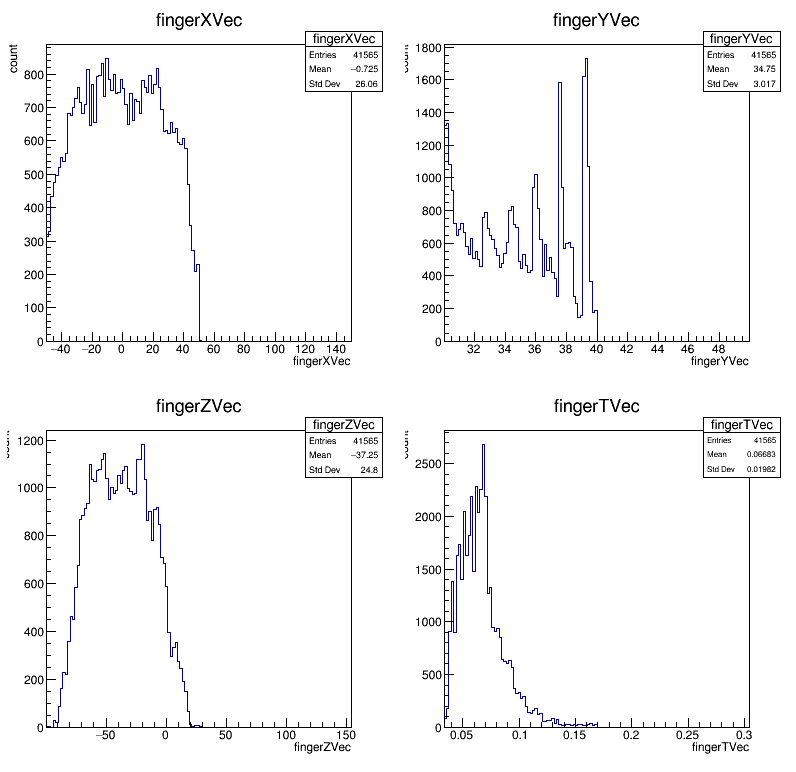

In [6]:
# Canvas 1

hFingerX = fdft.Histo1D('fingerXVec')
hFingerY = fdft.Histo1D('fingerYVec')
hFingerZ = fdft.Histo1D('fingerZVec')
hFingerT = fdft.Histo1D('fingerTVec')

c1 = root.TCanvas("c1","c1",800,800)
c1.Divide(2,2,0.01,0.01,0)

c1.cd(1)
hFingerX.Draw()
c1.cd(2)
hFingerY.Draw()
c1.cd(3)
hFingerZ.Draw()
c1.cd(4)
hFingerT.Draw()

c1.Draw()
c1.Print("plots/c1RA.pdf");

Info in <TCanvas::Print>: pdf file plots/c2RA.pdf has been created


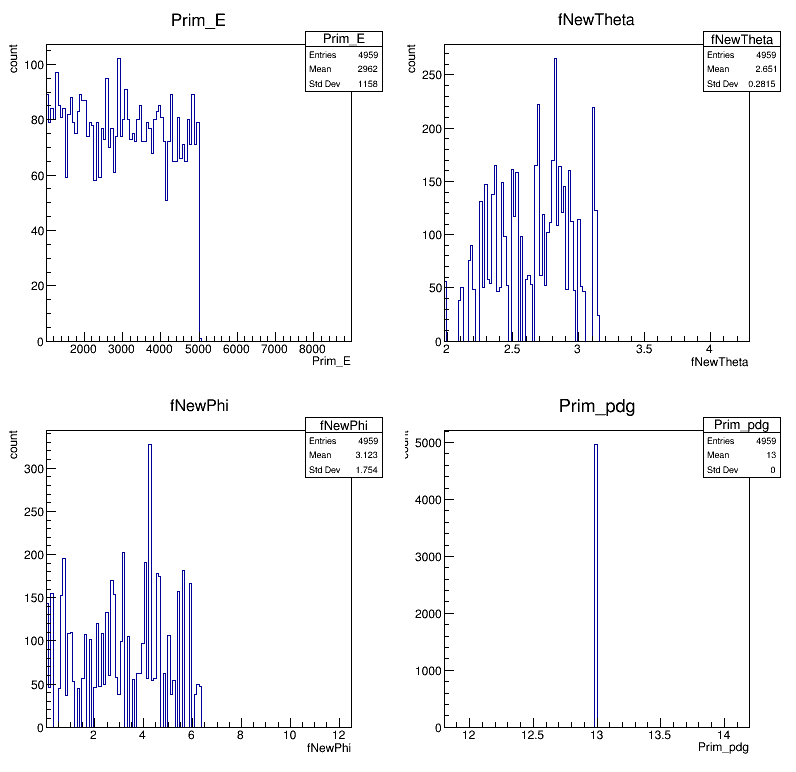

In [7]:
# Canvas 2

hPrimE = fdft.Histo1D('Prim_E')
hPrimTh = fdft.Histo1D('fNewTheta')
hPrimPh = fdft.Histo1D('fNewPhi')
hPrimPdg = fdft.Histo1D('Prim_pdg')

c2 = root.TCanvas("c2","c2",800,800)
c2.Divide(2,2,0.01,0.01,0)

c2.cd(1)
hPrimE.Draw()
c2.cd(2)
hPrimTh.Draw()
c2.cd(3)
hPrimPh.Draw()
c2.cd(4)
hPrimPdg.Draw()

c2.Draw()
c2.Print("plots/c2RA.pdf")


In [8]:
# Canvas 5

hAnaBarX = fdft.Histo1D('fingerXVec')
hAnaBarY = fdft.Histo1D('fingerYVec')
hAnaBarZ = fdft.Histo1D('fingerZVec')
hAnaBarT = fdft.Histo1D('fingerTVec')

c5 = root.TCanvas("c5","c5",800,800)
c5.Divide(2,2,0.01,0.01,0)

c5.cd(1)
hAnaBarX.Draw()
c5.cd(2)
hAnaBarY.Draw()
c5.cd(3)
hAnaBarZ.Draw()
c5.cd(4)
hAnaBarT.Draw()

c5.Draw()
c5.Print("plots/c5RA.pdf");

Elapsed time: 4.8833 seconds
